In [126]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [128]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)

In [129]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/neuroaging/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [130]:
metric = "adc"
distribution_metric = "qfmean"
data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


data["age_squared"] = data["age_at_scan"] ** 2
data["sex"] = data["sex"].map({"M": 0, "F": 1})

/tmp/ipykernel_200180/2526694603.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [131]:
metric_col = "volume" if metric == "gm_vol" else distribution_metric

In [132]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [133]:
import numpy as np
import pandas as pd


# ─────────────────────────────────────────────────────────────────────────────
def compute_poststrat_weights(
    sample_df: pd.DataFrame,
    pop_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    start_col: str = "range_start",
    end_col: str = "range_end",
    pop_total_col: str = "total",
    cap: float | None = None,
    return_bin_table: bool = False,
):
    """
    Post-stratification weights so that the age distribution of *sample_df*
    matches an external population distribution supplied in *pop_df*.

    Parameters
    ----------
    sample_df : DataFrame with an ``age_col`` column (years; int or float).
    pop_df    : DataFrame with columns
                    [start_col, end_col, pop_total_col].
                * Values in ``pop_total_col`` can be counts **or** percentages
                  (they are internally re-scaled to proportions).
                * The row order doesn’t matter; they will be sorted.
    cap       : Optional float.  If provided, weights are truncated at
                ``cap × mean(weight)`` and then re-scaled so mean(weight)=1.
    return_bin_table : If True, also return a DataFrame summarising
                       n_sample, n_pop, and weight_factor for every bin.

    Returns
    -------
    weights   : 1-D numpy array aligned with ``sample_df.index``.
    bin_table : (optional) tidy per-bin summary (see above).
    """

    # 1 ── tidy & validate the population table --------------------------------
    pop = (
        pop_df[[start_col, end_col, pop_total_col]]
        .dropna()
        .astype({start_col: int, end_col: int, pop_total_col: float})
        .sort_values(start_col)  # your CSV is descending; fix that
        .reset_index(drop=True)
    )

    if (pop[end_col] <= pop[start_col]).any():
        raise ValueError("Each range_end must exceed range_start.")

    if (pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values).any():
        overlap = pop.iloc[
            np.where(pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values)[0] + 1
        ][[start_col, end_col]]
        raise ValueError(
            "Age bins overlap (rows shown below) — "
            "merge / correct them before weighting:\n"
            f"{overlap}"
        )

    # 2 ── build right-inclusive bin edges  (···| s_i  …  e_i | s_{i+1} …) ----
    edges = pop[start_col].tolist() + [pop[end_col].iloc[-1]]

    # 3 ── assign every participant to a bin -----------------------------------
    s_bins = pd.cut(
        sample_df[age_col],
        bins=edges,
        right=True,
        include_lowest=True,
        labels=pop.index,  # categorical labels 0,1,…
    )

    # 4 ── compute *sample* and *population* proportions per bin --------------
    n_sample = s_bins.value_counts(sort=False).sort_index()
    prop_sample = n_sample / n_sample.sum()

    prop_pop = pop[pop_total_col] / pop[pop_total_col].sum()

    # 5 ── weight factor = pop_prop / sample_prop ------------------------------
    weight_factor = prop_pop / prop_sample.replace(0, np.nan)  # avoid /0 → NaN

    # 6 ── map factor back to each row ----------------------------------------
    w = s_bins.map(weight_factor).astype(float).to_numpy()
    w = np.where(np.isnan(w), 0.0, w)  # rows that fell outside bins → 0

    # 7 ── optional weight truncation (winsorisation) --------------------------
    if cap is not None and cap > 0:
        mean_pos = w[w > 0].mean()
        w = np.clip(w, 0, cap * mean_pos)

    # 8 ── re-scale so mean(weight > 0) == 1 -----------------------------------
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    # 9 ── return --------------------------------------------------------------
    if return_bin_table:
        bin_tbl = pd.DataFrame(
            {
                "n_sample": n_sample,
                "n_pop": prop_pop * n_sample.sum(),  # rescaled to sample size
                "prop_sample": prop_sample,
                "prop_pop": prop_pop,
                "weight_factor": weight_factor,
            }
        )
        return w, bin_tbl

    return w

In [134]:
# assign weights
data["weight"], _ = compute_poststrat_weights(
    data,
    israel_population,
    age_col="age_at_scan",
    cap=None,  # try None first; if still spiky, use 4 or 5
    return_bin_table=True,
)

In [135]:
from tqdm import tqdm
# Set up dataframes to store results

models = {}

for save_name in ["lin_unw", "lin_w", "quad_unw", "quad_w", "unw_compare", "w_compare"]:
    models[save_name] = pd.read_pickle(OUTPUT_DIR.with_name("fig2") / f"{save_name}_{metric}.pkl")



In [141]:
# Tell the pipeline which side of the parabola is “structural stabilisation”
orientation = {           # feel free to expand
    "gm_vol" : "max",      # concave-down expected
    "adc"    : "min",      # concave-up expected
    # "fa"   : "min",
    # "rd"   : "min",
}

def vertex_age(beta1, beta2):
    """Age at vertex of a quadratic   β0 + β1·x + β2·x²."""
    return -beta1 / (2 * beta2)

def stabilisation_age(metric, betas, pvalues, *, age_min=18, age_max=85):
    """
    betas = dict with keys "age" (β1) and "age_sq" (β2)
    Returns (age*, flagged)   where flagged=True if outside range or wrong shape.
    """
    want = orientation.get(metric, "min")       # default = 'min' if not listed
    β1, β2 = betas["age"], betas["age_sq"]
    p1, p2 = pvalues["age"], pvalues["age_sq"]
    # ── 1. Shape check  ────────────────────────────────────────────────
    if   (p2 > 0.05) or (want == "min" and β2 <= 0):
        # parabola opens down – no minimum inside; flag & push to boundary
        return age_min, True
    elif (p2 > 0.05) or (want == "max" and β2 >= 0):
        # parabola opens up – no maximum inside
        return age_max, True

    # ── 2. Compute vertex  ─────────────────────────────────────────────
    age_star = vertex_age(β1, β2)
    clipped  = False

    # clip to observed age window
    if age_star < age_min:
        age_star, clipped = age_min, True
    elif age_star > age_max:
        age_star, clipped = age_max, True

    return age_star, clipped


In [ ]:
alpha = 0.05
use_quad = models["w_compare"]["p_corrected"] < alpha

stab_df = parcels.copy()

age_min = np.nan

for i, row in parcels.iterrows():
    lm = models["lin_w"].loc[i,"model"]
    qm = models["quad_w"].loc[i,"model"]
    p = models["w_compare"].loc[i, "p_corrected"]
    if p < alpha and qm.params["age_squared"] != 0:
        β1 = qm.params["age_at_scan"]
        β2 = qm.params["age_squared"]
        p1 = qm.pvalues["age_at_scan"]
        p2 = qm.pvalues["age_squared"]
        age_star, clipped = stabilisation_age(metric, {"age": β1, "age_sq": β2}, {"age": p1, "age_sq": p2})
        chosen = "quadratic"
    else:
        age_star = age_min                     # or age_max / np.nan
        clipped   = False
        chosen    = "linear"

    
    # Save the results
    stab_df.loc[i, "age_star"] = age_star
    stab_df.loc[i, "clipped"] = clipped
    stab_df.loc[i, "chosen"] = chosen
    stab_df.loc[i, "p"] = p
    stab_df.loc[i, "β1"] = β1 if chosen=="quadratic" else lm.params["age_at_scan"]
    stab_df.loc[i, "β2"] = β2 if chosen=="quadratic" else 0.0
    stab_df.loc[i, "r2_lin"] = lm.rsquared_adj
    stab_df.loc[i, "r2_quad"] = qm.rsquared_adj

In [143]:
stab_df[stab_df["clipped"] == False].sort_values("age_star", ascending=False).head(20)

index                            name                     base_name  \
413    414                       PUT-DA-rh                        PUT-DA   
412    413                       PUT-VA-rh                        PUT-VA   
426    427                          aGP-rh                           aGP   
415    416                       PUT-DP-rh                        PUT-DP   
423    424                    NAc-shell-rh                     NAc-shell   
118    119  7Networks_LH_Limbic_TempPole_1  7networks_lh_limbic_temppole   
439    440                       PUT-VA-lh                        PUT-VA   
442    443                       PUT-DP-lh                        PUT-DP   
440    441                       PUT-DA-lh                        PUT-DA   
450    451                    NAc-shell-lh                     NAc-shell   
414    415                       PUT-VP-rh                        PUT-VP   
368    369     7Networks_RH_Default_Temp_3     7networks_rh_default_temp   
441    442                       PUT-VP-lh                        PUT-VP   
120    121  7Networks_LH_Limbic_TempPole_3  7networks_lh_limbic_temppole   
447    448                         lAMY-lh                          lAMY   
324    325  7Networks_RH_Limbic_TempPole_1  7networks_rh_limbic_temppole   
420    421                         lAMY-rh                          lAMY   
123    124  7Networks_LH_Limbic_TempPole_6  7networks_lh_limbic_temppole   
327    328  7Networks_RH_Limbic_TempPole_4  7networks_rh_limbic_temppole   
119    120  7Networks_LH_Limbic_TempPole_2  7networks_lh_limbic_temppole   

                         Label Name    network          component hemisphere  \
413    Putamen, dorso-anterior part  subcortex            Putamen          R   
412   Putamen, ventro-anterior part  subcortex            Putamen          R   
426         Pallidum, anterior part  subcortex           Pallidum          R   
415   Putamen, dorso-posterior part  subcortex            Putamen          R   
423        Nucleus Accumbens, shell  subcortex  Nucleus Accumbens          R   
118    7Networks_LH_Limbic_TempPole     limbic      temporal pole          L   
439   Putamen, ventro-anterior part  subcortex            Putamen          L   
442   Putamen, dorso-posterior part  subcortex            Putamen          L   
440    Putamen, dorso-anterior part  subcortex            Putamen          L   
450        Nucleus Accumbens, shell  subcortex  Nucleus Accumbens          L   
414  Putamen, ventro-posterior part  subcortex            Putamen          R   
368       7Networks_RH_Default_Temp    default           temporal          R   
441  Putamen, ventro-posterior part  subcortex            Putamen          L   
120    7Networks_LH_Limbic_TempPole     limbic      temporal pole          L   
447       Amygdala, lateral nucleus  subcortex           Amygdala          L   
324    7Networks_RH_Limbic_TempPole     limbic      temporal pole          R   
420       Amygdala, lateral nucleus  subcortex           Amygdala          R   
123    7Networks_LH_Limbic_TempPole     limbic      temporal pole          L   
327    7Networks_RH_Limbic_TempPole     limbic      temporal pole          R   
119    7Networks_LH_Limbic_TempPole     limbic      temporal pole          L   

      age_star clipped     chosen              p            β1            β2  \
413  56.137391   False  quadratic   4.034925e-18 -2.991140e-06  2.664125e-08   
412  55.945610   False  quadratic   4.836344e-24 -2.249677e-06  2.010593e-08   
426  54.638950   False  quadratic   7.215195e-10 -4.673795e-06  4.276981e-08   
415  54.306784   False  quadratic   8.359454e-20 -3.385458e-06  3.116975e-08   
423  53.570060   False  quadratic   2.626876e-43 -3.148245e-06  2.938437e-08   
118  53.042109   False  quadratic   1.235175e-02 -8.372376e-07  7.892198e-09   
439  52.880636   False  quadratic   1.595498e-34 -3.032810e-06  2.867600e-08   
442  52.161217   False  quadratic   1.409225e-11 -2.416688e-06  2.316556e-08   
440  49

/tmp/ipykernel_200180/2961652673.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


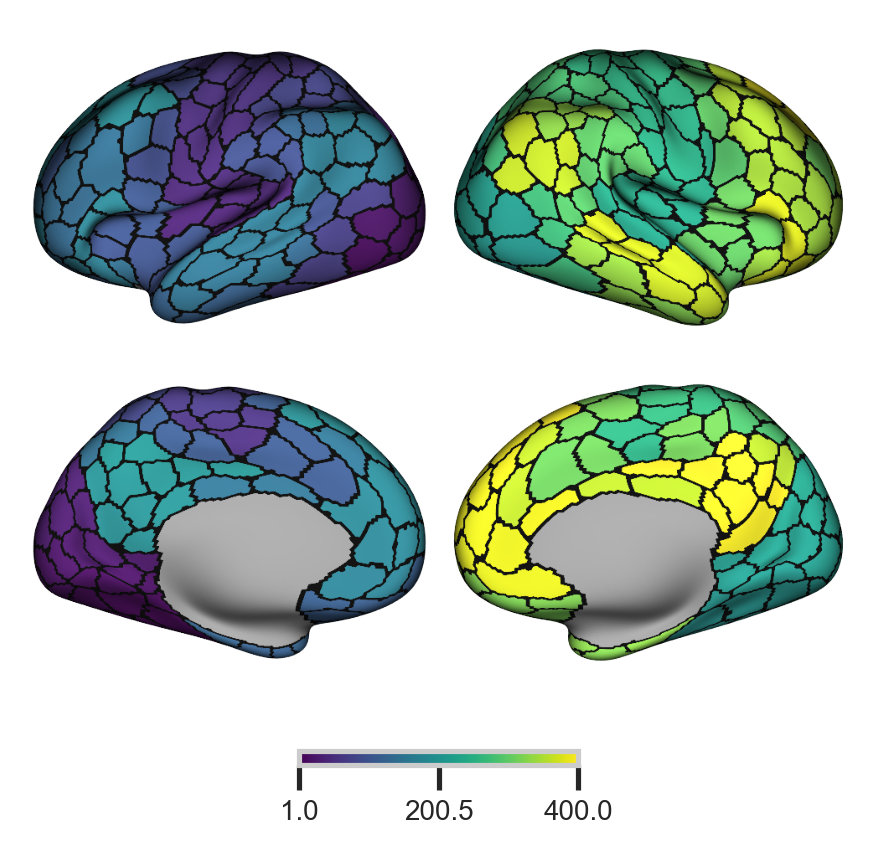

In [144]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']
p = Plot(lh, rh)

# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation('schaefer')
p.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=True)

p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
            as_outline=True, cbar=False)
fig = p.build()
fig.show()

In [146]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [147]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region":[],"value":[],"Hemisphere":[]}

vis_df = stab_df
value_column = "age_star"

for i, row in vis_df.iterrows():
    label = row[region_col]
    value = row[value_column]
    # if (row["p_corrected"] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
    if row["clipped"]:
        value = np.nan
    # else:
    #     value = np.nan
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            value_map[label] = value

vec = np.vectorize(lambda x: value_map.get(x, np.nan))
data_lh = vec(lh_parc)
data_rh = vec(rh_parc)

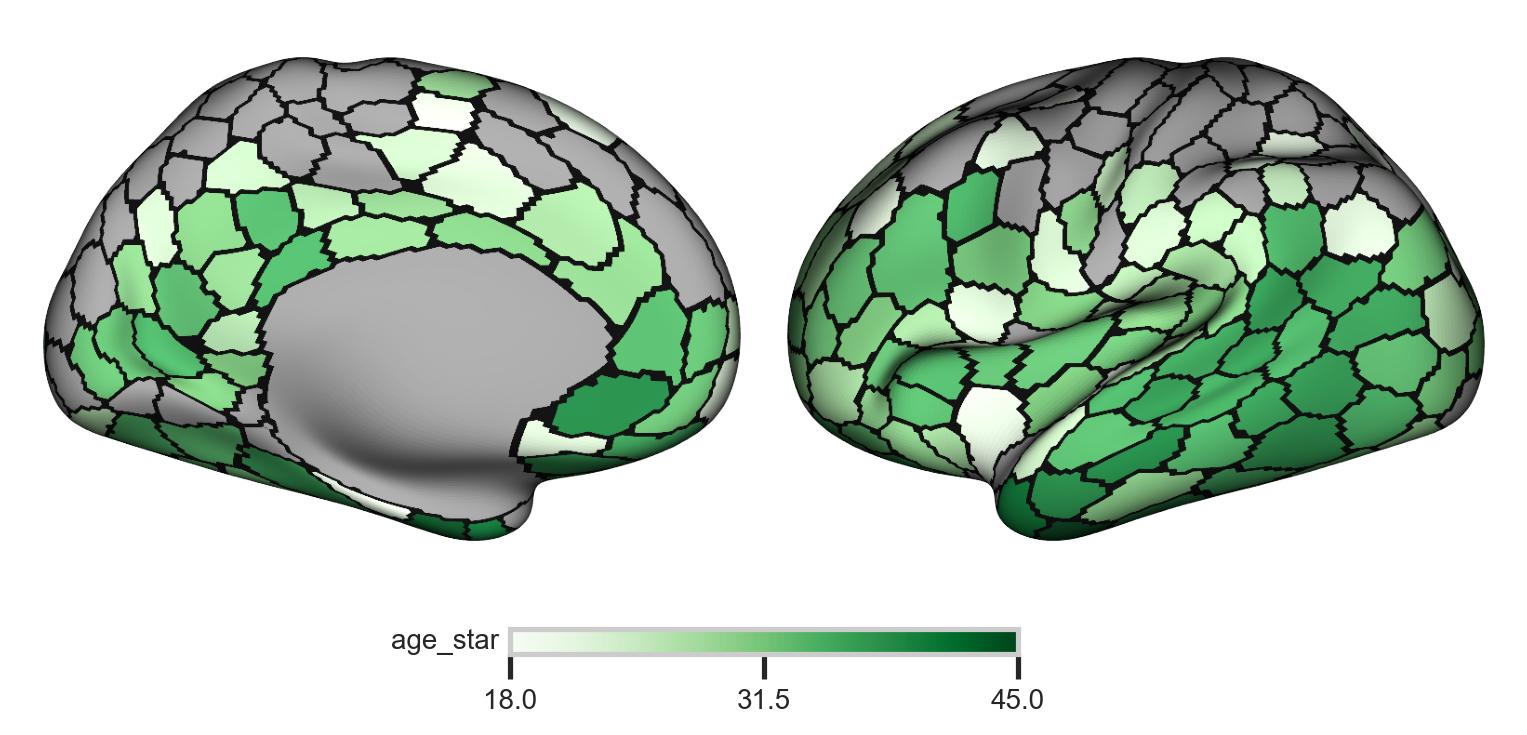

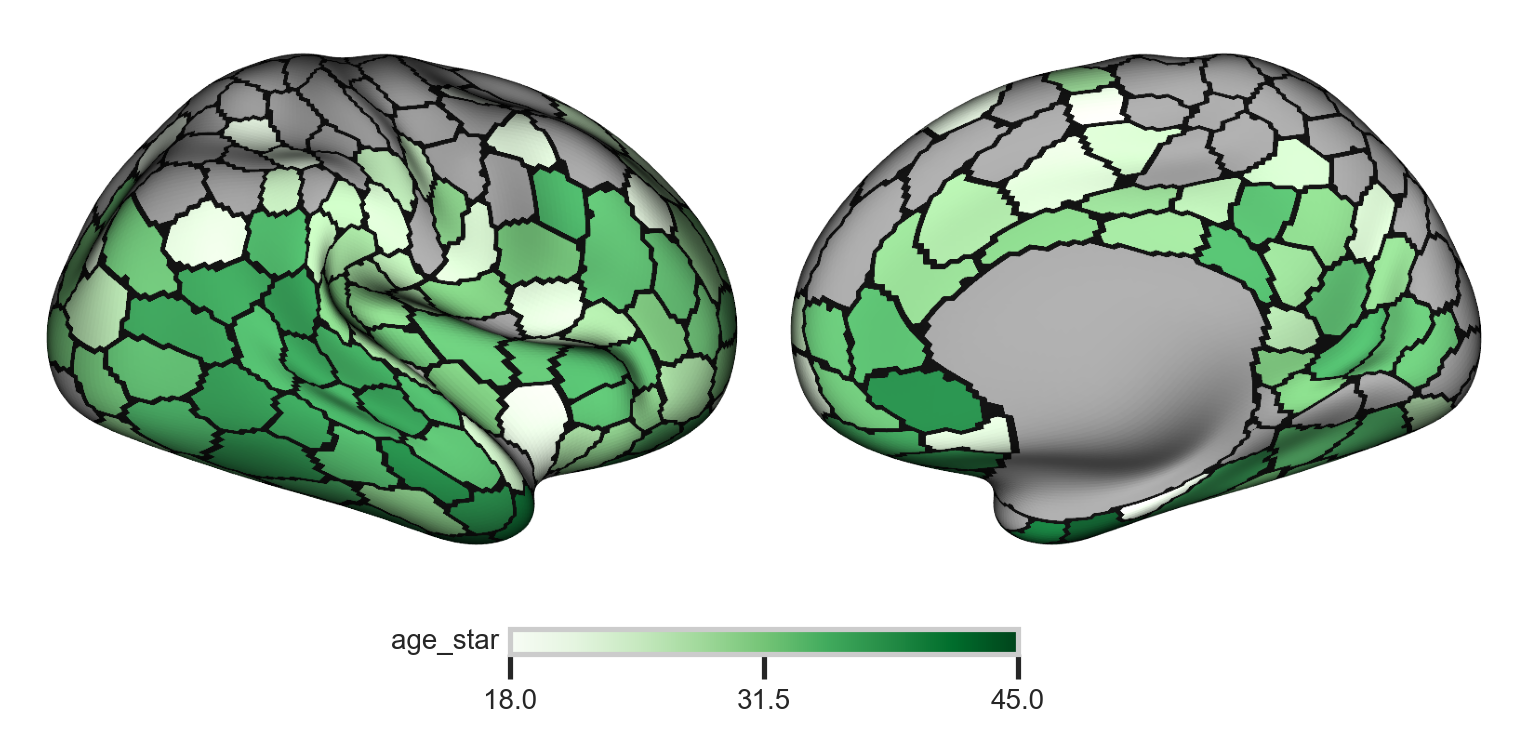

In [175]:
vmin = 18
vmax = 45

for hemi, hemi_data, key, vis_data in zip(["L","R"],[lh,rh], ["left","right"], [data_lh, data_rh]):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    p = Plot(
        hemi_data,
        # rh,
        # views="latmed",  # L-lat, L-med, R-lat, R-med
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",
        mirror_views=True,
        views=["medial","lateral"]
    )

    # ---- main data layer -------------------------------------------------
    # If your metric is centred on 0 (e.g., t-values) use TwoSlopeNorm for symmetry
    # norm = TwoSlopeNorm(
    #     vmin=np.nanmin([data_lh, data_rh]), ,vmax=np.nanmax([data_lh, data_rh])
    # )

    p.add_layer(
        {"left": data_lh, "right": data_rh},
        # cmap="Purples",
        cmap="Greens",
        color_range=(vmin,vmax),
        # color_range=(2.5,3.5),
        cbar_label=value_column,
    )
    # ---- outline layer ---------------------------------------------------
    # Re-use the label arrays; surfplot draws borders when as_outline=True
    p.add_layer({"left": lh_parc, "right": rh_parc}, cmap="gray", as_outline=True, cbar=False)


    # fig = p.build(cbar_kws=dict(location="bottom", decimals=2))
    fig = p.build()

    # save figure
    savefig_nice(fig, OUTPUT_DIR / f"fig3_{metric}_{hemi}_{value_column}.png", dpi=400)

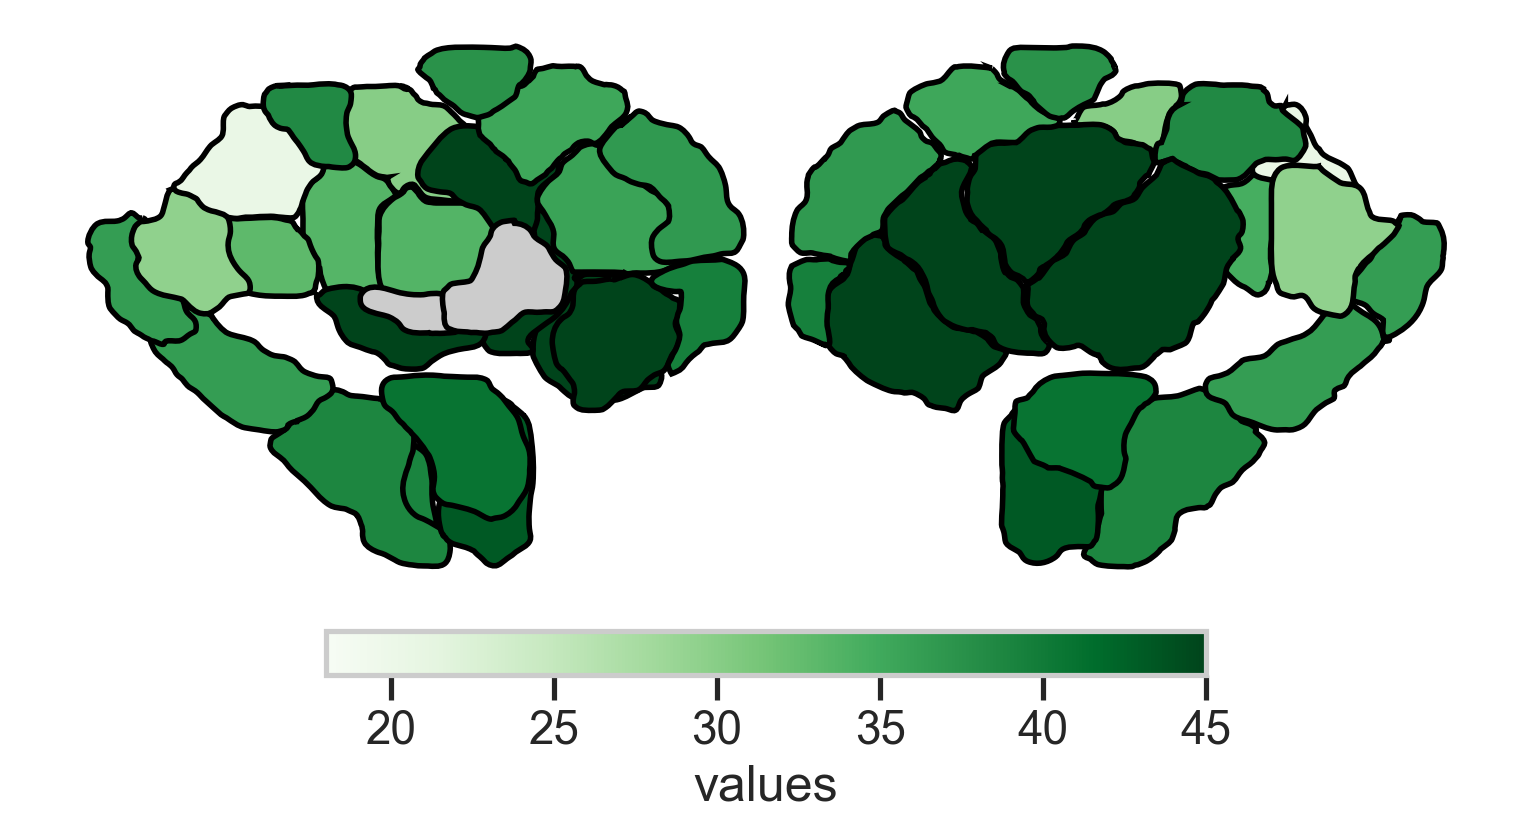

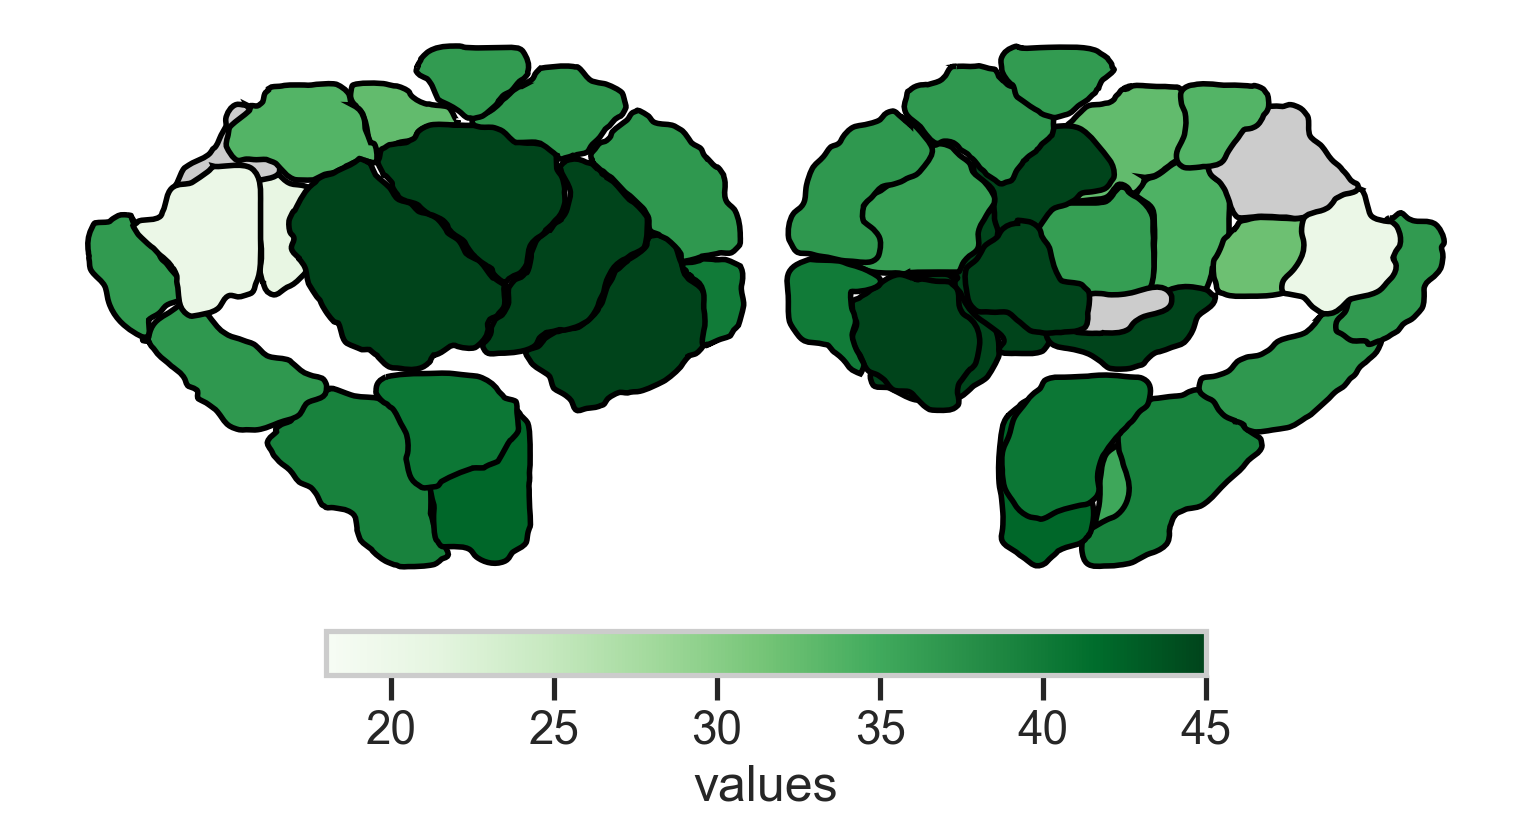

In [176]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L","R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        # cmap="Purples",
        cmap="Greens",
        line_color="black",
        line_thickness=2,
        vmin = vmin,
        vmax = vmax,
        show_figure=False
    )

    # save figure
    savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)


In [264]:

stab_df[(stab_df["clipped"] == True) & (stab_df["component"] == "somatomotor")].sort_values("p", ascending=False).head(100)

index                    name            base_name           Label Name  \
50      51  7Networks_LH_SomMot_20  7networks_lh_sommot  7Networks_LH_SomMot   
65      66  7Networks_LH_SomMot_35  7networks_lh_sommot  7Networks_LH_SomMot   
64      65  7Networks_LH_SomMot_34  7networks_lh_sommot  7Networks_LH_SomMot   
265    266  7Networks_RH_SomMot_36  7networks_rh_sommot  7Networks_RH_SomMot   
53      54  7Networks_LH_SomMot_23  7networks_lh_sommot  7Networks_LH_SomMot   
63      64  7Networks_LH_SomMot_33  7networks_lh_sommot  7Networks_LH_SomMot   
43      44  7Networks_LH_SomMot_13  7networks_lh_sommot  7Networks_LH_SomMot   
58      59  7Networks_LH_SomMot_28  7networks_lh_sommot  7Networks_LH_SomMot   
268    269  7Networks_RH_SomMot_39  7networks_rh_sommot  7Networks_RH_SomMot   
257    258  7Networks_RH_SomMot_28  7networks_rh_sommot  7Networks_RH_SomMot   
255    256  7Networks_RH_SomMot_26  7networks_rh_sommot  7Networks_RH_SomMot   
266    267  7Networks_RH_SomMot_37  7networks_rh_sommot  7Networks_RH_SomMot   
230    231   7Networks_RH_SomMot_1  7networks_rh_sommot  7Networks_RH_SomMot   
264    265  7Networks_RH_SomMot_35  7networks_rh_sommot  7Networks_RH_SomMot   
248    249  7Networks_RH_SomMot_19  7networks_rh_sommot  7Networks_RH_SomMot   
261    262  7Networks_RH_SomMot_32  7networks_rh_sommot  7Networks_RH_SomMot   
56      57  7Networks_LH_SomMot_26  7networks_lh_sommot  7Networks_LH_SomMot   
258    259  7Networks_RH_SomMot_29  7networks_rh_sommot  7Networks_RH_SomMot   
62      63  7Networks_LH_SomMot_32  7networks_lh_sommot  7Networks_LH_SomMot   
51      52  7Networks_LH_SomMot_21  7networks_lh_sommot  7Networks_LH_SomMot   
46      47  7Networks_LH_SomMot_16  7networks_lh_sommot  7Networks_LH_SomMot   
256    257  7Networks_RH_SomMot_27  7networks_rh_sommot  7Networks_RH_SomMot   
52      53  7Networks_LH_SomMot_22  7networks_lh_sommot  7Networks_LH_SomMot   
59      60  7Networks_LH_SomMot_29  7networks_lh_sommot  7Networks_LH_SomMot   
254    255  7Networks_RH_SomMot_25  7networks_rh_sommot  7Networks_RH_SomMot   
60      61  7Networks_LH_SomMot_30  7networks_lh_sommot  7Networks_LH_SomMot   
251    252  7Networks_RH_SomMot_22  7networks_rh_sommot  7Networks_RH_SomMot   
67      68  7Networks_LH_SomMot_37  7networks_lh_sommot  7Networks_LH_SomMot   
262    263  7Networks_RH_SomMot_33  7networks_rh_sommot  7Networks_RH_SomMot   
250    251  7Networks_RH_SomMot_21  7networks_rh_sommot  7Networks_RH_SomMot   
61      62  7Networks_LH_SomMot_31  7networks_lh_sommot  7Networks_LH_SomMot   

         network    component hemisphere  age_star clipped     chosen  \
50   somatomotor  somatomotor          L      18.0    True  quadratic   
65   somatomotor  somatomotor          L      18.0    True  quadratic   
64   somatomotor  somatomotor          L      18.0    True  quadratic   
265  somatomotor  somatomotor          R      18.0    True  quadratic   
53   somatomotor  somatomotor          L      18.0    True  quadratic   
63   somatomotor  somatomotor          L      18.0    True  quadratic   
43   somatomotor  somatomotor          L      18.0    True  quadratic   
58   somatomotor  somatomotor          L      18.0    True  quadratic   
268  somatomotor  somatomotor          R      18.0    True  quadratic   
257  somatomotor  somatomotor          R      18.0    True  quadratic   
255  somatomotor  somatomotor          R      18.0    True  quadratic   
266  somatomotor  somatomotor          R      18.0    True  quadratic   
230  somatomotor  somatomotor          R      18.0    True  quadratic   
264  somatomotor  somatomotor          R      18.0    True  quadratic   
248  somatomotor  somatomotor          R      18.0    True  quadratic   
261  somatomotor  somatomotor          R      18.0    True  quadratic   
56   somatomotor  somatomotor          L      18.0    True  quadratic   
258  somatomotor  somatomotor          R      18.0    True  quadratic   
62   somatomotor  somatomotor          L      18.0    Tru

/tmp/ipykernel_200180/3172951896.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


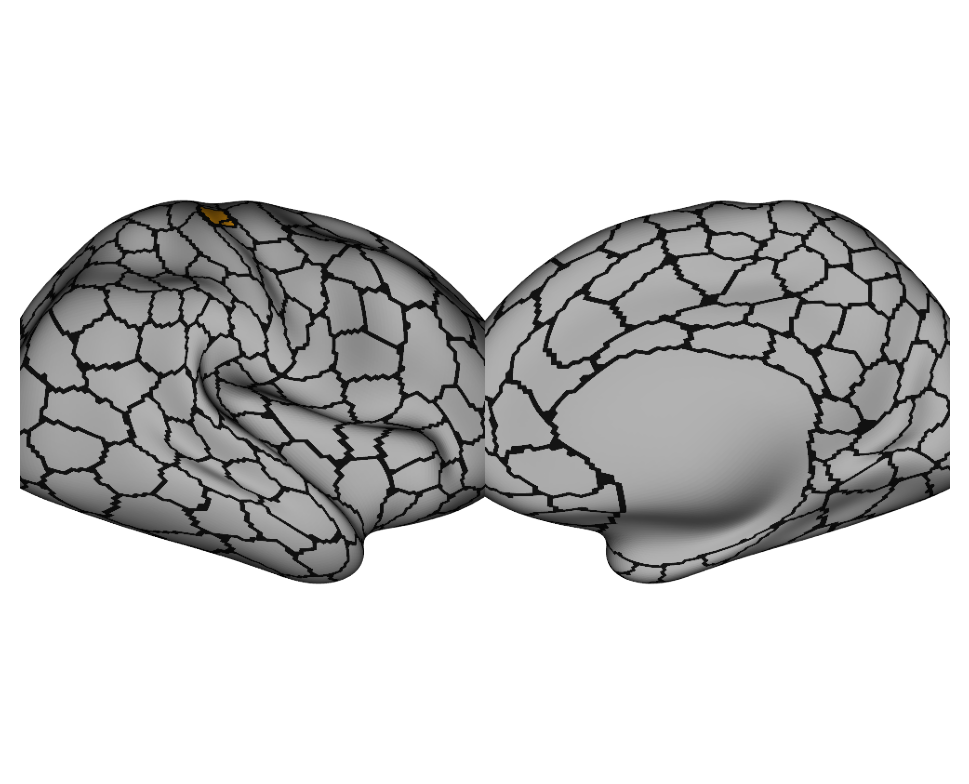

In [269]:
import numpy as np

region_numbers = [259]

parc = rh_parc
h = rh

# zero-out all regions except 71 and 72
regions = np.where(np.isin(parc, region_numbers), parc, 0)
from matplotlib.colors import ListedColormap

colors = ["orange", "steelblue"]
cmap = ListedColormap(colors, "regions", N=2)

p = Plot(h, views=["medial","lateral"])
p.add_layer(regions, cmap=cmap, cbar=False)
p.add_layer(regions, cmap="gray", as_outline=True, cbar=False)
p.add_layer({"left": lh_parc, "right": rh_parc}, cmap="gray", as_outline=True, cbar=False)
fig = p.build()
fig.show()
# sphinx_gallery_thumbnail_number = 3

In [232]:
example_rois = {
    413: {"name": "R. Putamen", "component":"Basal Ganglia"},
    447: {"name": "L. Amygdala", "component":"Limbic System"},
    168: {"name": "L. PFC", "component":"Prefrontal Cortex"},
    179: {"name": "L. PFC", "component":"Prefrontal Cortex"},
}

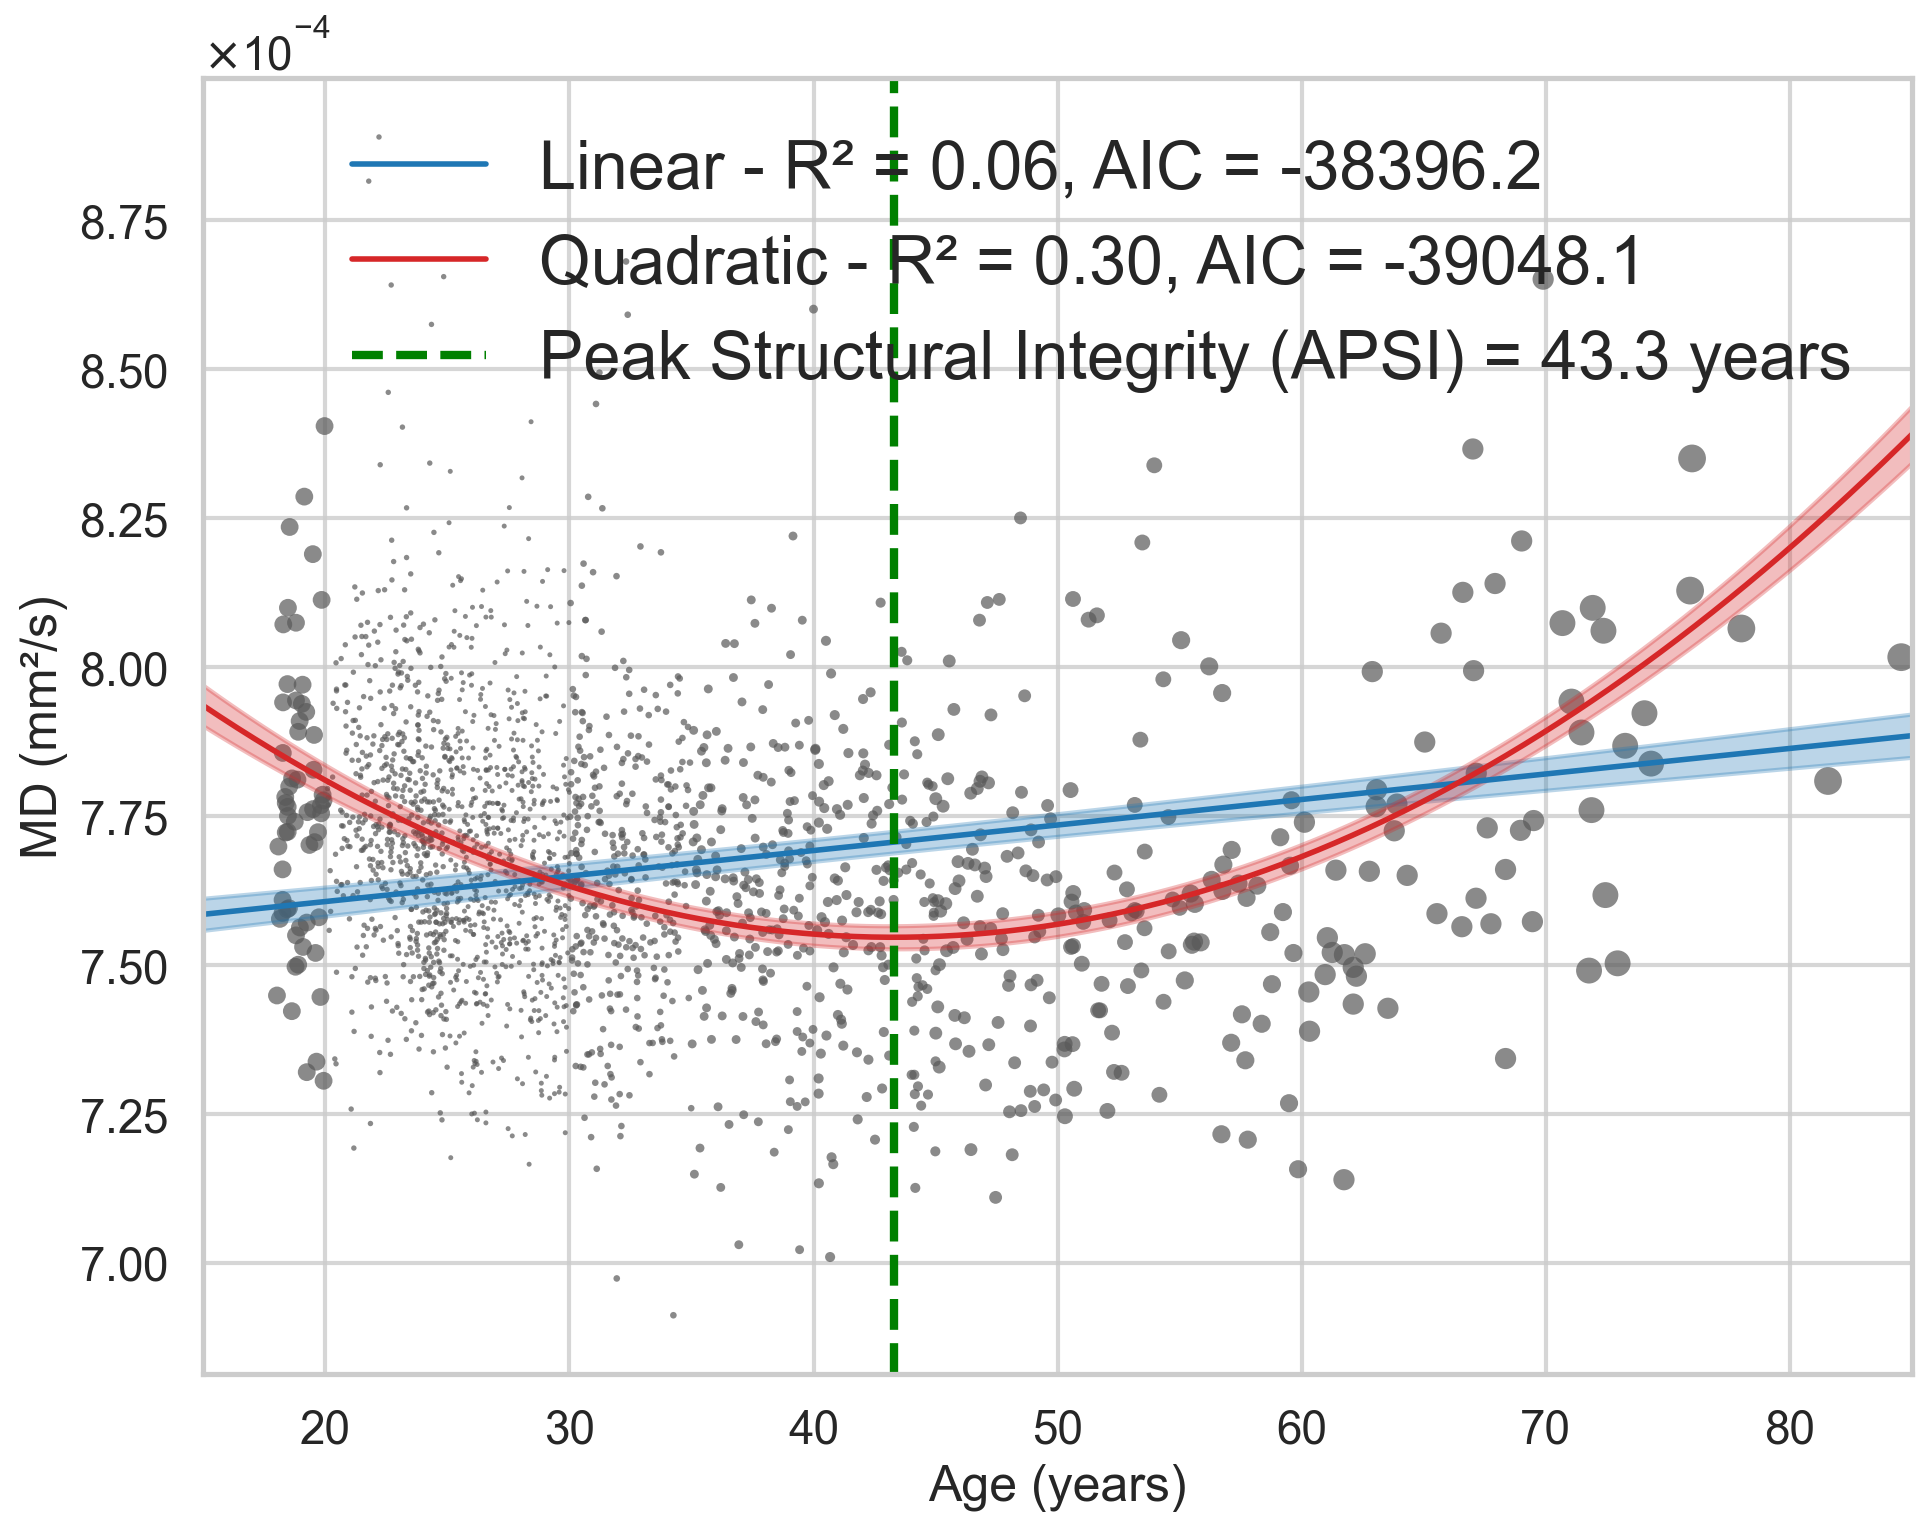

In [288]:
age_min, age_max = 15, 85
age_col = "age_at_scan"

i = 447

lm = models["lin_w"].loc[i, "model"]
qm = models["quad_w"].loc[i, "model"]

d = data[data[region_col] == parcels.loc[i, region_col]].copy()
# remove outliers
d = d[(d[metric_col] > d[metric_col].quantile(0.001)) & (d[metric_col] < d[metric_col].quantile(0.999))]
# d = d[(d[metric_col] > d[metric_col].quantile(0.001))]

# ────────────────── Panel B: Predicted trajectory ± 95 % CI ──────────────

fig, ax = plt.subplots(figsize=(10, 8))

# 3. Prediction frame

# ── 3. Prediction grid ──────────────────────────────────────────────
age_grid = np.linspace(age_min, age_max, 300)
grid_df = pd.DataFrame({age_col: age_grid, "age_squared": age_grid ** 2})

# add any covariates present in models (use median/mode)
covs = [v for v in qm.model.exog_names if v not in ["Intercept", age_col, "age_squared"]]
for c in covs:
    if pd.api.types.is_numeric_dtype(data[c]):
        grid_df[c] = d[c].median()
    else:
        grid_df[c] = d[c].mode()[0]


# 4. Get predictions & CI
for tag, model in [("Linear", lm), ("Quadratic", qm)]:
    pr  = model.get_prediction(grid_df)
    ci  = pr.conf_int(alpha=0.05)
    grid_df[f"{tag}_fit"] = pr.predicted_mean
    grid_df[f"{tag}_lo"]  = ci[:, 0]
    grid_df[f"{tag}_hi"]  = ci[:, 1]

# 5. Plot
ax.clear()  # reuse the same axes handle

# Background scatter (down-sample for speed / clarity)
sizes = np.clip(d["weight"] * 10, 0, 100)
sns.scatterplot(
    data=d,
    x=age_col,
    y=metric_col,
    alpha=0.7,
    s=sizes,
    edgecolor="none",
    ax=ax,
    legend=False,
    color=COL_REF,
)

# # Fit lines & ribbons
for tag, color, model in zip(
    ["Linear", "Quadratic"], [COL_RAW, COL_WEIGHTED], [lm, qm]
):
    label = f"{tag} - R² = {model.rsquared:.2f}, AIC = {model.aic:.1f}"
    ax.plot(age_grid, grid_df[f"{tag}_fit"], label=label, lw=2, color=color)
    ax.fill_between(
        age_grid,
        grid_df[f"{tag}_lo"],
        grid_df[f"{tag}_hi"],
        color=color,
        alpha=0.3,
    )

# add age star
stab_age = stab_df.loc[i, "age_star"]

if stab_age > 18:
    lab = f"Peak Structural Integrity (APSI) = {stab_age:.1f} years"
else:
    lab = f"Peak Structural Integrity (APSI) ≤ {stab_age:.1f} years"

ax.axvline(
    stab_age,
    color="green",
    linestyle="--",
    lw=3,
    label=lab,
)

ax.ticklabel_format(
        style="sci", axis="y", scilimits=(0, 0), useMathText=True
    )
if metric == "gm_vol":
    ylabel = "GM Volume (mm³)"
    # set y axis format to cm instead of mm
else:
    ylabel = "MD (mm²/s)"

ax.set(
    xlabel="Age (years)",
    ylabel=ylabel,
    xlim=(age_min, age_max),
)

# title = "(A) GM Volume" if metric == "gm_vol" else "(B) Mean Diffusivity"
# suptitle = example_rois.get(i, {}).get("name", f"Region {i}")

# ax.set_title("Predicted trajectory (± 95 % CI)")
# ax.set_title(title, fontsize=30, pad=20)
ax.legend(frameon=False, fontsize=24)


# model_type = "quad" if use_quadratic else "linear"
savefig_nice(
    fig,
    OUTPUT_DIR / f"fig4_{i+1}.png",
    tight=True,
    dpi=300,
)

In [198]:
subcort_df.loc[48]

region        49
value          1
Hemisphere     L
Name: 48, dtype: object

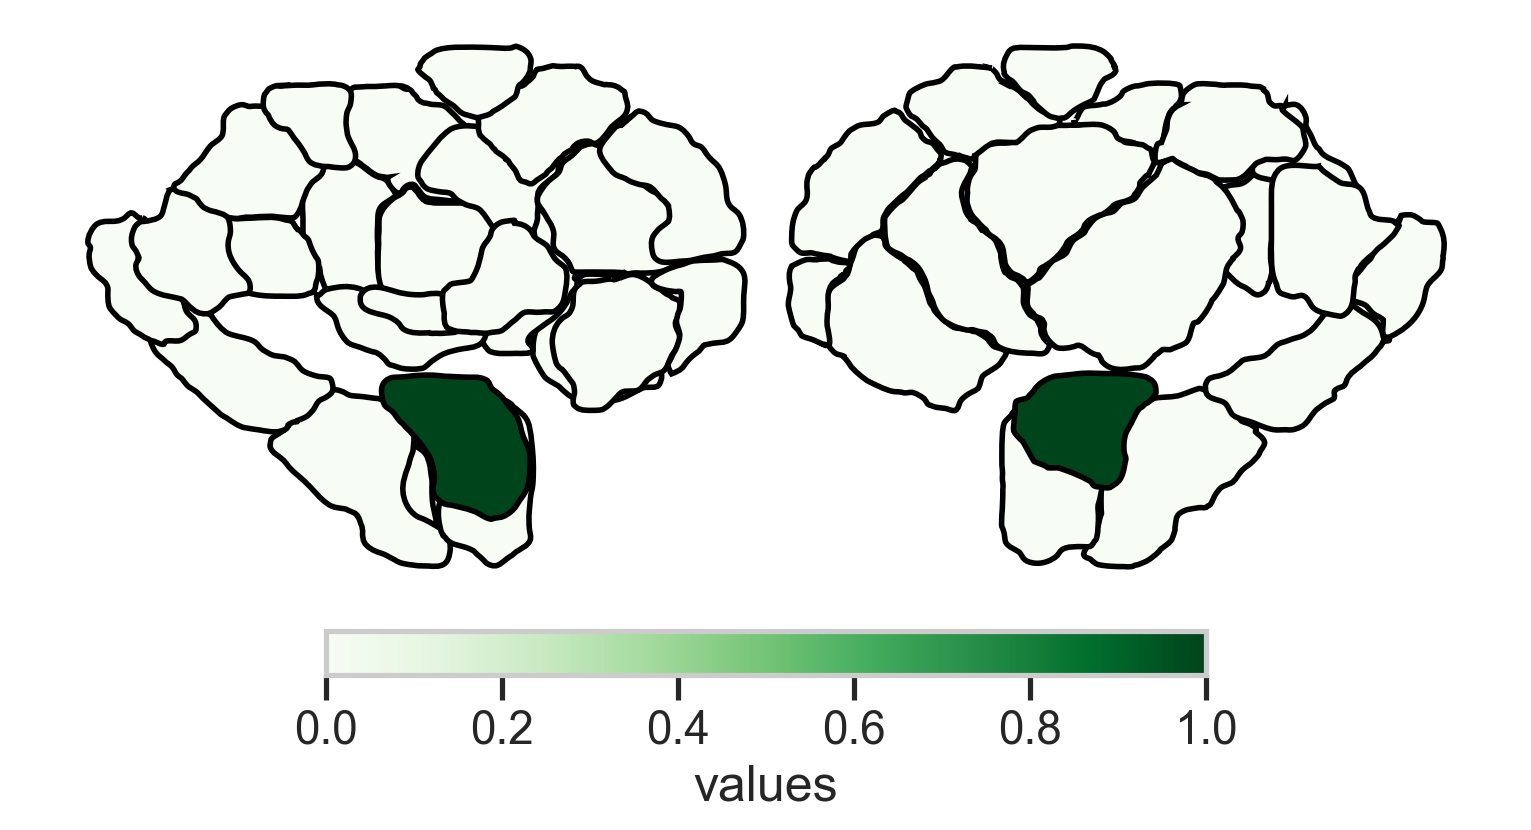

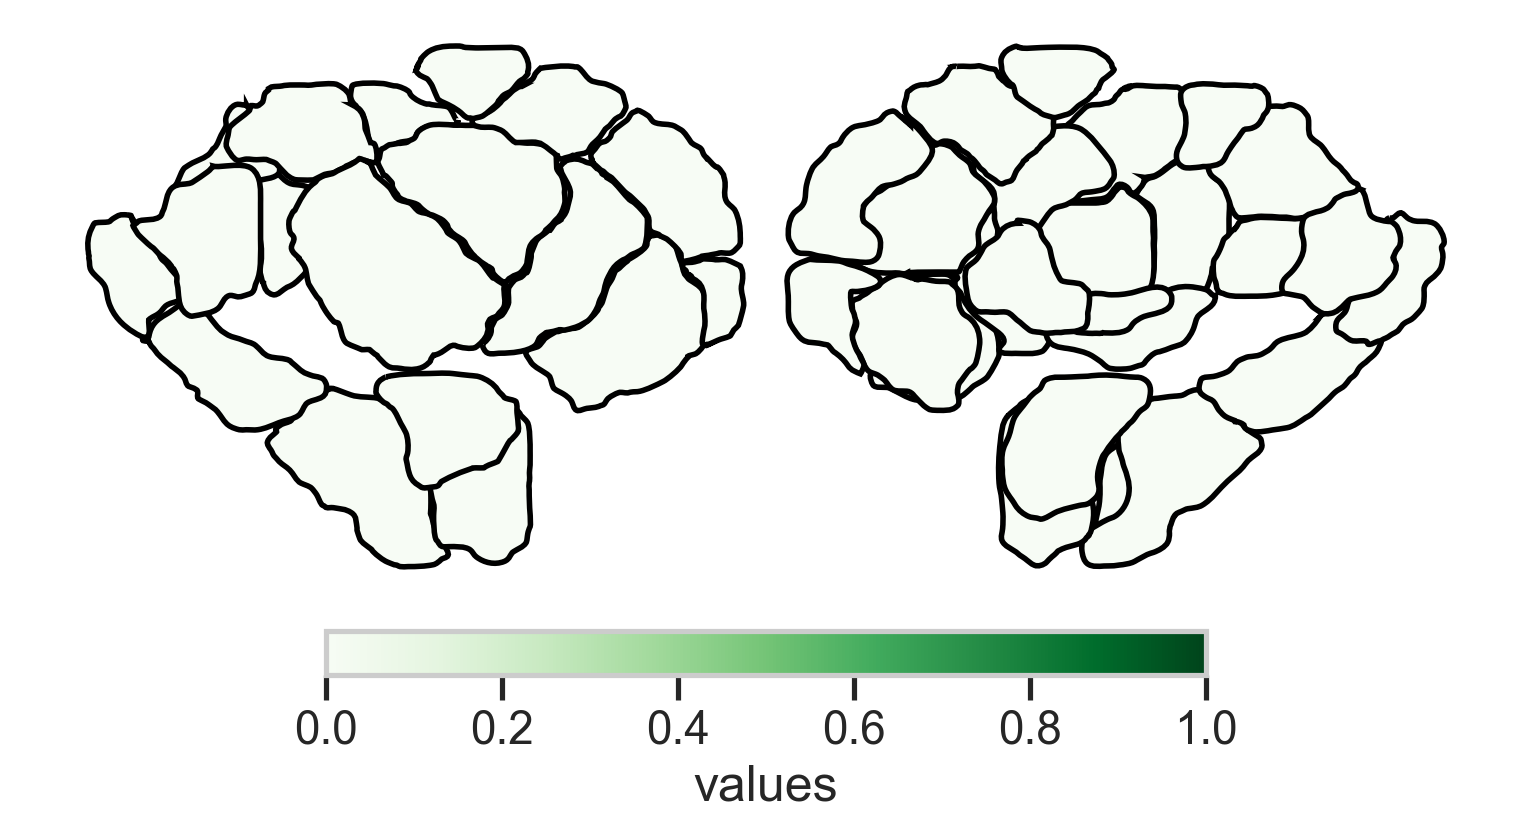

In [197]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
subcort_df["value"] = 0
subcort_df.loc[48, "value"] = 1
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L","R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        # cmap="Purples",
        cmap="Greens",
        line_color="black",
        line_thickness=2,
        vmin = 0,
        vmax = 1,
        show_figure=False
    )

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib import font_manager as fm

# template colour palette
COL_GREY = "#575A5C"  # primary charcoal (axes / default bars)
COL_TEAL = "#21A0A0"  # accent / second category
COL_GRID = "#E5E5E5"  # light gridlines
COL_SAME = "#D81B60"  # Deep pink/magenta
# COL_SAME = COL_GREY
# COL_DIFF_REP = "#1E88E5"  # Blue for diff subj (repeated)
COL_DIFF_REP = COL_TEAL
# COL_DIFF_SINGLE = "#43A047"  # Green for diff subj (single)
COL_DIFF_SINGLE = COL_GREY  # Green for diff subj (single)

In [152]:
i = 413
age_min = 18
age_max = 85
n_grid = 100

age_col = "age_at_scan"

d = data[data[region_col] == parcels.loc[i, region_col]].copy()

lm_res = models["lin_w"].loc[i,"model"]
qm_res = models["quad_w"].loc[i, "model"]
stab_row = stab_df.loc[i]
age_star = stab_row["age_star"]

# ── 3. Prediction grid ──────────────────────────────────────────────
age_grid = np.linspace(age_min, age_max, n_grid)
grid_df = pd.DataFrame({age_col: age_grid, "age_squared": age_grid ** 2})

# add any covariates present in models (use median/mode)
covs = [v for v in qm_res.model.exog_names if v not in ["Intercept", age_col, "age_squared"]]
for c in covs:
    if pd.api.types.is_numeric_dtype(data[c]):
        grid_df[c] = d[c].median()
    else:
        grid_df[c] = d[c].mode()[0]

In [153]:
# predictions
def pred_ci(model):
    pr = model.get_prediction(grid_df)
    ci = pr.conf_int(alpha=0.05)
    return pr.predicted_mean, ci[:, 0], ci[:, 1]


fit_lin, lo_lin, hi_lin = pred_ci(lm_res)
fit_quad, lo_quad, hi_quad = pred_ci(qm_res)

(0.00036080126405744497, 0.0008791290586740551)

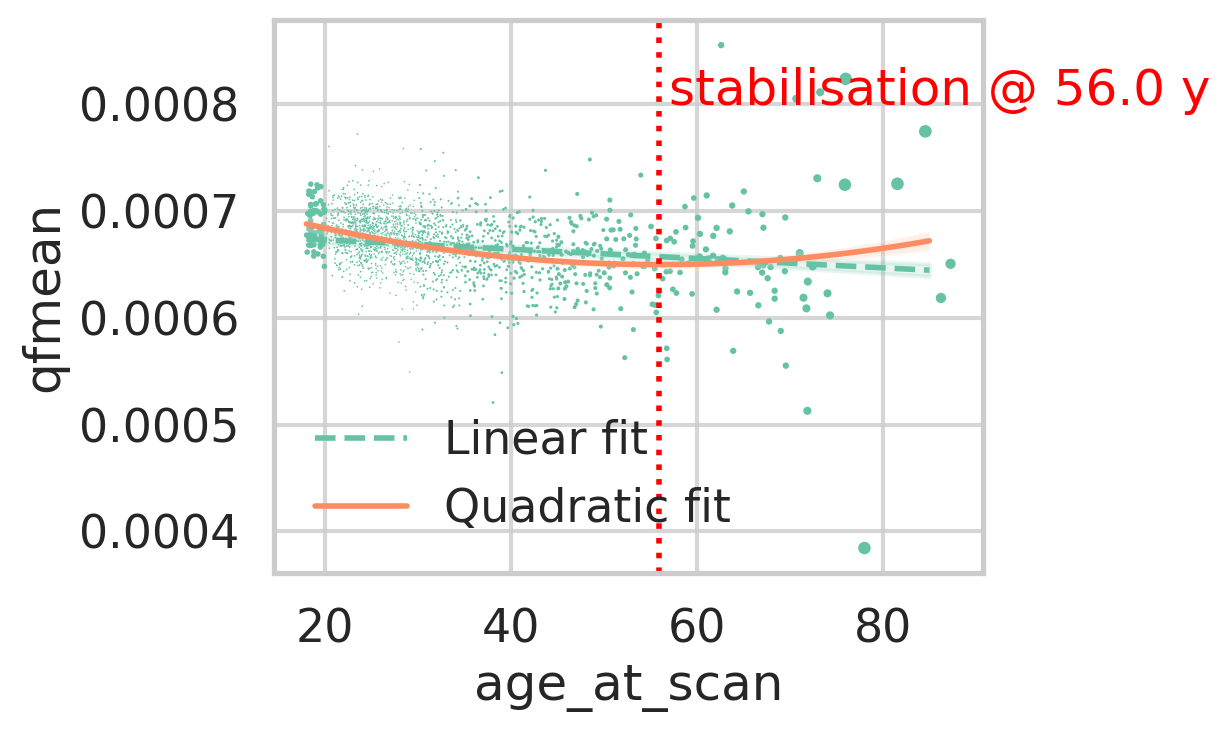

In [155]:
weight_col = "weight"
# ── 4. Plot ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4))

# scatter of raw points
size_kw = {} if weight_col is None else {"s":  d[weight_col]}
sns.scatterplot(
    data=d,
    x=age_col,
    y=metric_col,
    # alpha=scatter_alpha,
    edgecolor="none",
    ax=ax,
    legend=False,
    **size_kw,
)

# linear fit
ax.plot(age_grid, fit_lin, ls="--", lw=2, label="Linear fit")
ax.fill_between(age_grid, lo_lin, hi_lin, alpha=0.15, color="C0")

# quadratic fit
ax.plot(age_grid, fit_quad, lw=2, label="Quadratic fit")
ax.fill_between(age_grid, lo_quad, hi_quad, alpha=0.15)

# stabilisation age
ax.axvline(age_star, ls=":", lw=2, color="red")
ax.text(
    age_star + 1,
    ax.get_ylim()[1] * 0.95,
    f"stabilisation @ {age_star:.1f} y",
    color="red",
    va="top",
)

# ax.set(xlabel="Age (years)", ylabel=f"{metric} value", title=f"Region {region_id} • {metric}")
ax.legend(frameon=False)
fig.tight_layout()
ax.set_ylim(
    # ax.get_ylim()[0] * 0.95,
    # ax.get_ylim()[1] * 1.05,
    # 0.0005,0.0008
)

In [ ]:
# ── Helper: per-region demonstration plot ──────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_region_fit(
    region_id,
    metric,
    df_long,
    *,
    lm_dict,
    qm_dict,
    stab_df,
    age_col="age_at_scan",
    value_col="value",
    weight_col=None,  # set to "weight" if you want weighted sizes
    age_min=18,
    age_max=85,
    n_grid=300,
    scatter_alpha=0.25,
):
    """
    Parameters
    ----------
    region_id   : hashable region label used in lm_dict / qm_dict keys
    metric      : str, metric name (e.g. "gm_vol" or "adc")
    df_long     : DataFrame with columns [region_id, age_col, value_col, weight_col]
    lm_dict     : {region_id: statsmodels.RegressionResults}  (linear fits)
    qm_dict     : {region_id: statsmodels.RegressionResults}  (quadratic fits)
    stab_df     : DataFrame with columns ['region', 'stabilisation_age', 'model']
    weight_col  : if not None, point size ∝ weight
    """
    # ── 1. Slice data for this region ────────────────────────────────────
    d = df_long[df_long["region"] == region_id].copy()

    # ── 2. Retrieve models & stabilisation age ──────────────────────────
    lm_res = lm_dict[region_id]
    qm_res = qm_dict[region_id]
    stab_row = stab_df.loc[stab_df["region"] == region_id].iloc[0]
    age_star = stab_row["age_star"]

    # ── 3. Prediction grid ──────────────────────────────────────────────
    age_grid = np.linspace(age_min, age_max, n_grid)
    grid_df = pd.DataFrame({age_col: age_grid})

    # add any covariates present in models (use median/mode)
    covs = [
        v for v in lm_res.model.exog_names if v not in ["Intercept", age_col, f"I({age_col} ** 2)"]
    ]
    for c in covs:
        if pd.api.types.is_numeric_dtype(df_long[c]):
            grid_df[c] = df_long[c].median()
        else:
            grid_df[c] = df_long[c].mode()[0]

    # predictions
    def pred_ci(model):
        pr = model.get_prediction(grid_df)
        ci = pr.conf_int(alpha=0.05)
        return pr.predicted_mean, ci[:, 0], ci[:, 1]

    fit_lin, lo_lin, hi_lin = pred_ci(lm_res)
    fit_quad, lo_quad, hi_quad = pred_ci(qm_res)

    # ── 4. Plot ─────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6, 4))

    # scatter of raw points
    size_kw = {} if weight_col is None else {"s": 30 * d[weight_col]}
    sns.scatterplot(
        data=d,
        x=age_col,
        y=value_col,
        alpha=scatter_alpha,
        edgecolor="none",
        ax=ax,
        legend=False,
        **size_kw,
    )

    # linear fit
    ax.plot(age_grid, fit_lin, ls="--", lw=2, label="Linear fit")
    ax.fill_between(age_grid, lo_lin, hi_lin, alpha=0.15)

    # quadratic fit
    ax.plot(age_grid, fit_quad, lw=2, label="Quadratic fit")
    ax.fill_between(age_grid, lo_quad, hi_quad, alpha=0.15)

    # stabilisation age
    ax.axvline(age_star, ls=":", lw=2, color="red")
    ax.text(
        age_star + 1,
        ax.get_ylim()[1] * 0.95,
        f"stabilisation @ {age_star:.1f} y",
        color="red",
        va="top",
    )

    ax.set(xlabel="Age (years)", ylabel=f"{metric} value", title=f"Region {region_id} • {metric}")
    ax.legend(frameon=False)
    fig.tight_layout()
    return fig, ax

